## FFT solver for 1D Gross-Pitaevski equation

We look for the complex function $\psi(x)$ satisfying the GP equation


$-\frac{1}{2}(i\partial_x - \Omega)^2\psi+g|\psi|^2\psi = \mu \psi$,

with periodic boundary conditions.

Import libraries and general definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from scipy.integrate import odeint
import numpy.linalg as lin
%matplotlib inline
pi=np.pi

Data block

In [2]:
Zmax=2*np.pi;   # Half grid length
Npoint=128;   # Number of grid points
Nparticle=50; # Number of particles
a_s=0.5; # scattering length 
whoz=1.0; # harmonic oscilator angular frequency
#mu=3.27; #Chemical potential
#Omega=pi/(2*Zmax); #reference frame velocity

Derived quantities

In [3]:
NormWF=1.0/(2*Zmax); # Wave function (WF) norm
gint=2*a_s*Nparticle*NormWF;# nonlinear-term strength
Dz=2*Zmax/Npoint;#length step size
Dk=pi/Zmax; # momentum step size, maximum wave number is Kmax=Dk*Npoint/2
Kmax=Dk*(Npoint//2) # maximum momentum

Utilities

In [4]:
def changeFFTposition(f,N,j):  # change the order in vectors from FFT
# f(0...N-1) is the vector to order
# N is the vector dimension
# j is a switch indicating the change direction
# physical order is f=[(-(Zmax-Dz):Dz:-Dz) (0:Dz:Zmax) ]
# FFT order is f=[(0:Dk:kmax) (-(kmax-kz):kz:-kz)]
    f1 = f*1
    if (j==1):  # from physical to FFT order
        for i in range(0,N//2-1) : 
            f1[i] = f[N//2-1+i];
            f1[N//2+1+i] = f[i];
        f1[N//2-1] = f[N-2];        
        f1[N//2] = f[N-1];
    elif (j==0): # from FFT to physical order
        for i in range(0,N//2-1) : 
            f1[i] = f[N//2+1+i];
            f1[N//2+1+i] = f[i+2];
        f1[N//2-1] = f[0];        
        f1[N//2] = f[1];        
    else:
        print("error in changeFFTposition(f,N,j): j must be 0 or 1...")
    return f1

Grid definitions: physical and momentum space

In [5]:
z = np.arange(-Zmax+Dz,Zmax+Dz,Dz) # physical (R-space) grid points in ascending order
# zp=[(0:Dz:Zmax) (-(Zmax-Dz):Dz:-Dz)]; 
zp = changeFFTposition(z,Npoint,1) # (R-space) grid points with FFT order
#print("grid points (K-order): "); print(zp)
#print(" R-order: "); print(z)
#
# kp=[(0:Dk:Kmax) (-(Kmax-Dk):Dk:-Dk)]; # grid points (K-space), FFT order
kp = np.arange(-Kmax+Dk,Kmax+Dk,Dk)
kp = changeFFTposition(kp,Npoint,1)
#print("momentum values: "); print(kp)

Define operators

In [6]:
Ekin_K = 0.5*(kp**2); # Kinetic energy in K space
# print("Ekin: "); print(Ekin_K)
Vpot_R = 0.5*whoz*zp**2; # Potential energy in R space
# print("Vpot: "); print(Vpot_R)    

Main functions

In [7]:
def Energy(c): # Energy calculation
    global gint, Vpot_R, Ekin_K, Npoint
    ek = sum(Ekin_K*abs(c)**2) # Kinetic energy in K
    psi = ifft(c)*Npoint; # wf FFT to R
    ep = sum(Vpot_R*abs(psi)**2)/Npoint; # Potential energy
    ei = 0.5*gint*sum(abs(psi)**4)/Npoint; # Interaction energy
    em =  ek+ep+ei;
    chem_pot = em+ei;
    return em, chem_pot, ek, ep, ei
#
def H1DGP(cr,t,tau): # time evolution operator so that: \partial_t psi  = -i H1DGP psi
    global gint, Vpot_R, Ekin_K, Npoint
    #
    # cr is the wave function psi in K3 written as a real vector: cr=[psi.real psi.imag]
    # t is the time (which is not used if H)
    # tau is the imaginary time 
    #
    [c1,c2]=np.split(cr, 2) # turn to complex variables
    c=c1+1j*c2
    psi = ifft(c)*Npoint; # FFT to R3
    HRpsi = (Vpot_R+gint*(abs(psi)**2))*psi; # evolution Epot+Eint in R3
    HKpsi = fft(HRpsi)/Npoint; # + FFT to K3
    if (tau!=0.0): 
        c = -tau *( Ekin_K*c + HKpsi )
    else:
        c = -1j *( Ekin_K*c + HKpsi )
    return np.concatenate([c.real,c.imag])
#
def gaussian(x,n,x0,w): # gaussian wf in  K3
    fx = np.pi**0.25*np.exp(-0.5*((x-x0)/w)**2); # gausian in R3
    return fft(fx)/n;  # FFT to K3
#
def normaliza(c): # normalization to 1
    norm = lin.norm(c)
    if ((norm-1.0)>1.0e-4): # check norm
        print("normalization from: ",norm)
    return c/norm

Choose initial wafe function and evolve in time

In [8]:
# initial wf: Gaussian centered at x=0 and width=1
c0=normaliza(gaussian(zp,Npoint,0,1)); # wf at t=0
# evolve in time: parameters
t0=0.0 
evolution_time=25.0
Nstep = 5000; # number of intermediate steps with outputs
tevol=np.empty([Nstep+1]) # time vector
energy_cicle=np.empty([Nstep+1,5]) # put the energies in a matrix
energy_cicle[0,:] = Energy(c0) # Energies at t=0
print("Energies:          Emed    mu    Ekin    Epot    Eint")
print("         initial = %g %g %g %g %g"%(Energy(c0)))
# print("$\psi(t=0)$: "); print(ct) 
c0r=np.concatenate([c0.real,c0.imag]) # prepare real vector for odeint
tevol[0]=t0
Dt = evolution_time/(1.0*Nstep)
Dtint=[0, Dt]
tau = 0.1 # imaginary time
for i in range(1, Nstep+1): # time evolution cicle
    tevol[i] = tevol[i-1] + Dt
    ctr = odeint(H1DGP,c0r,Dtint,args=(tau,)); # calculate ctr(t)
    [c1r,c2r]=np.split(ctr[1,:], 2)
    c = normaliza(c1r+1j*c2r); # check norm in the wf
    energy_cicle[i,:] = Energy(c)
    c0r=np.concatenate([c.real,c.imag])
print("         final   = %g %g %g %g %g"%(Energy(c))) # check energies
print("Energy change at last step  = %g"%(energy_cicle[Nstep,0]-energy_cicle[Nstep-1,0]))

Energies:          Emed    mu    Ekin    Epot    Eint
         initial = 10.4736 20.4471 0.25 0.25 9.97356
         final   = 5.39137 8.92526 0.0494713 1.808 3.53389
Energy change at last step  = -3.06871e-09


Plot convergence during the evolution in the average energy per particle

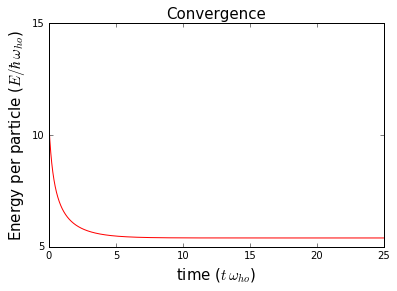

In [9]:
plt.title('Convergence',fontsize=15)
plt.xlabel('time ($t \, \\omega_{ho}$)',fontsize=15)
plt.ylabel('Energy per particle ($E/\\hbar \,\\omega_{ho}$)',fontsize=15)
#plt.axis([-Zmax,Zmax,0, 8])
plt.xticks(np.arange(0, tevol[Nstep]+1,tevol[Nstep]/5))
plt.locator_params('y',nbins=3)
plt.plot(tevol, energy_cicle[:,0], 'r-')
#plt.plot(z, psi, 'r.')

Plot the final density (or wave function)

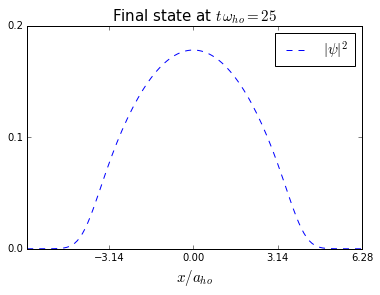

In [10]:
cc = ifft(c)*Npoint*NormWF**0.5 # FFT from K3 to R3 and include the wf norm
psi = changeFFTposition(cc,Npoint,0) # psi is the final wave function
# plot features
plt.title('Final state at $t \,\\omega_{ho}=%g$'%(tevol[Nstep]),fontsize=15)
plt.xlabel('$x/a_{ho}$',fontsize=15)
#plt.ylabel('$\\psi\,(x)$',fontsize=15)
#plt.axis([-Zmax,Zmax,0, 8])
plt.xticks(np.arange(-Zmax, Zmax+1,Zmax/2))
plt.locator_params('y',nbins=3)
#plt.plot(z, psi.real, 'r.',label='real$(\psi)$')
#plt.plot(z, psi.imag, 'b--',label='imag$(\psi)$')
plt.plot(z, abs(psi)**2, 'b--',label='$|\psi|^2$') # plot density
plt.legend(fontsize=15)